
# Lesson 12 — Backpropagation & Improving Neural Networks (CS229-style)

This lesson extends Lesson 11 by adding:

- **Binary cross-entropy loss**
- **Backpropagation** (chain rule) for a 2-layer MLP
- **Vectorization across samples**
- **Gradient checking** (finite differences)
- Practical improvements:
  - Activation choices (tanh / ReLU)
  - Initialization (why scaling matters)
  - Optimization: GD vs Momentum vs Adam

> **Goal:** write backprop once, trust it with gradient checks, then train reliably.



## 0) Setup

We’ll work with the same **2D XOR-like dataset** so the improvement is obvious.


In [31]:

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)


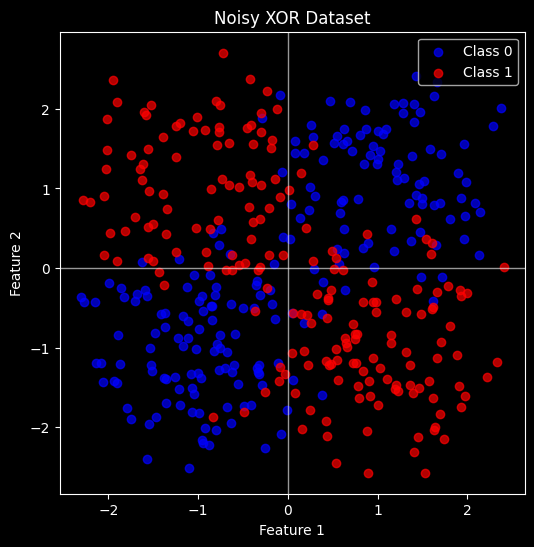

In [32]:

# XOR dataset (noisy)
n = 400
X = np.random.uniform(-2, 2, size=(n,2))
y = ((X[:,0] > 0) ^ (X[:,1] > 0)).astype(int)  # XOR labels
X += 0.35*np.random.randn(n,2)

plt.figure(figsize=(6,6))
plt.scatter(X[y==0,0], X[y==0,1], color="blue", alpha=0.7, label="Class 0")
plt.scatter(X[y==1,0], X[y==1,1], color="red",  alpha=0.7, label="Class 1")
plt.axvline(0, color="white", linewidth=1, alpha=0.6)
plt.axhline(0, color="white", linewidth=1, alpha=0.6)
plt.title("Noisy XOR Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(loc="upper right")
plt.show()



## 1) Model: 2-layer MLP
$$
Z_1 = XW_1 + b_1,\quad A_1 = g(Z_1)
$$
$$
Z_2 = A_1W_2 + b_2,\quad \hat{y} = \sigma(Z_2)
$$

Binary cross-entropy:
$$
\mathcal{L} = -\frac{1}{m}\sum_{i=1}^m \big(y^{(i)}\log(\hat{y}^{(i)}) + (1-y^{(i)})\log(1-\hat{y}^{(i)})\big)
$$


In [33]:

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def tanh(z):
    return np.tanh(z)

def relu(z):
    return np.maximum(0, z)

def d_tanh(a):
    # derivative using activation a = tanh(z)
    return 1 - a**2

def d_relu(z):
    return (z > 0).astype(float)

def bce_loss(yhat, y):
    eps = 1e-9
    yhat = np.clip(yhat, eps, 1-eps)
    return -np.mean(y*np.log(yhat) + (1-y)*np.log(1-yhat))



## 2) Forward + Backward (Vectorized)

CS229 backprop identity for sigmoid + BCE:
$$
\frac{\partial \mathcal{L}}{\partial Z_2} = \hat{y} - y
$$

Everything below is batch-vectorized (no per-sample loops).


In [34]:

def init_params(d_in, h, seed=0, scheme="xavier"):
    rng = np.random.default_rng(seed)
    if scheme == "small":
        W1 = rng.standard_normal((d_in, h)) * 0.01
        W2 = rng.standard_normal((h, 1)) * 0.01
    elif scheme == "xavier":
        W1 = rng.standard_normal((d_in, h)) * np.sqrt(1/d_in)
        W2 = rng.standard_normal((h, 1)) * np.sqrt(1/h)
    elif scheme == "he":
        W1 = rng.standard_normal((d_in, h)) * np.sqrt(2/d_in)
        W2 = rng.standard_normal((h, 1)) * np.sqrt(2/h)
    else:
        raise ValueError("scheme must be one of: small, xavier, he")
    b1 = np.zeros((1, h))
    b2 = np.zeros((1, 1))
    return {"W1":W1, "b1":b1, "W2":W2, "b2":b2}

def forward(X, params, activation="tanh"):
    W1, b1, W2, b2 = params["W1"], params["b1"], params["W2"], params["b2"]
    Z1 = X @ W1 + b1
    if activation == "tanh":
        A1 = tanh(Z1)
    elif activation == "relu":
        A1 = relu(Z1)
    else:
        raise ValueError("activation must be tanh or relu")
    Z2 = A1 @ W2 + b2
    Yhat = sigmoid(Z2)
    cache = {"X":X, "Z1":Z1, "A1":A1, "Z2":Z2, "Yhat":Yhat}
    return Yhat, cache

def backward(y, params, cache, activation="tanh"):
    X, Z1, A1, Yhat = cache["X"], cache["Z1"], cache["A1"], cache["Yhat"]
    m = X.shape[0]
    y = y.reshape(-1,1)

    dZ2 = (Yhat - y)                           # (m,1)
    dW2 = (A1.T @ dZ2) / m                     # (h,1)
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    dA1 = dZ2 @ params["W2"].T                 # (m,h)

    if activation == "tanh":
        dZ1 = dA1 * d_tanh(A1)                 # (m,h)
    elif activation == "relu":
        dZ1 = dA1 * d_relu(Z1)                 # (m,h)
    else:
        raise ValueError("activation must be tanh or relu")

    dW1 = (X.T @ dZ1) / m                      # (d,h)
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    return {"dW1":dW1, "db1":db1, "dW2":dW2, "db2":db2}



## 3) Gradient Checking (Finite Differences)

$$
\frac{\partial \mathcal{L}}{\partial \theta} \approx \frac{\mathcal{L}(\theta+\epsilon)-\mathcal{L}(\theta-\epsilon)}{2\epsilon}
$$

If max relative error is around **1e-6 to 1e-4**, you're good.


In [35]:

def pack_params(params):
    W1, b1, W2, b2 = params["W1"], params["b1"], params["W2"], params["b2"]
    return np.concatenate([W1.ravel(), b1.ravel(), W2.ravel(), b2.ravel()])

def unpack_params(theta, d_in, h):
    i = 0
    W1 = theta[i:i+d_in*h].reshape(d_in,h); i += d_in*h
    b1 = theta[i:i+h].reshape(1,h); i += h
    W2 = theta[i:i+h].reshape(h,1); i += h
    b2 = theta[i:i+1].reshape(1,1); i += 1
    return {"W1":W1, "b1":b1, "W2":W2, "b2":b2}

def loss_from_theta(theta, X, y, d_in, h, activation):
    params = unpack_params(theta, d_in, h)
    yhat, _ = forward(X, params, activation=activation)
    return bce_loss(yhat, y.reshape(-1,1))

def grad_check(X, y, params, activation="tanh", eps=1e-5, n_checks=12):
    d_in = X.shape[1]
    h = params["W1"].shape[1]
    theta0 = pack_params(params)

    yhat, cache = forward(X, params, activation=activation)
    grads = backward(y, params, cache, activation=activation)
    grad_vec = np.concatenate([
        grads["dW1"].ravel(),
        grads["db1"].ravel(),
        grads["dW2"].ravel(),
        grads["db2"].ravel()
    ])

    rng = np.random.default_rng(0)
    idxs = rng.choice(len(theta0), size=n_checks, replace=False)

    rel_errors = []
    for idx in idxs:
        t_plus = theta0.copy();  t_plus[idx] += eps
        t_minus = theta0.copy(); t_minus[idx] -= eps
        Lp = loss_from_theta(t_plus, X, y, d_in, h, activation)
        Lm = loss_from_theta(t_minus, X, y, d_in, h, activation)
        num = (Lp - Lm) / (2*eps)
        ana = grad_vec[idx]
        rel = abs(num - ana) / max(1e-8, abs(num) + abs(ana))
        rel_errors.append(rel)

    return idxs, np.array(rel_errors)

params_gc = init_params(d_in=2, h=6, seed=1, scheme="xavier")
Xs = X[:60]
ys = y[:60]
idxs, rel_err = grad_check(Xs, ys, params_gc, activation="tanh", eps=1e-5, n_checks=15)

print("Gradient check relative errors:")
print(rel_err)
print("max rel error:", rel_err.max())


Gradient check relative errors:
[5.23774401e-10 3.49678120e-10 5.67954488e-10 1.36769814e-10
 1.07771870e-08 6.37011092e-10 7.80512117e-10 1.83042471e-10
 1.27766635e-10 4.65697617e-10 7.37830066e-11 1.34217537e-09
 1.29041776e-10 6.04472596e-11 5.64170366e-10]
max rel error: 1.077718700022073e-08



## 4) Training Loops: GD, Momentum, Adam


In [36]:

def predict_class(X, params, activation="tanh"):
    p, _ = forward(X, params, activation=activation)
    return (p.reshape(-1) >= 0.5).astype(int)

def accuracy(X, y, params, activation="tanh"):
    return np.mean(predict_class(X, params, activation=activation) == y)

def train_gd(X, y, params, activation="tanh", lr=0.05, steps=4000):
    hist = {"loss":[], "acc":[]}
    for t in range(steps):
        yhat, cache = forward(X, params, activation=activation)
        L = bce_loss(yhat, y.reshape(-1,1))
        grads = backward(y, params, cache, activation=activation)

        params["W1"] -= lr * grads["dW1"]
        params["b1"] -= lr * grads["db1"]
        params["W2"] -= lr * grads["dW2"]
        params["b2"] -= lr * grads["db2"]

        if t % 100 == 0 or t == steps-1:
            hist["loss"].append(L)
            hist["acc"].append(accuracy(X, y, params, activation=activation))
    print("GD   final loss:", hist["loss"][-1], "final acc:", hist["acc"][-1])
    return params, hist

def train_momentum(X, y, params, activation="tanh", lr=0.05, steps=4000, beta=0.9):
    v = {k:np.zeros_like(params[k]) for k in params}
    hist = {"loss":[], "acc":[]}
    for t in range(steps):
        yhat, cache = forward(X, params, activation=activation)
        L = bce_loss(yhat, y.reshape(-1,1))
        grads = backward(y, params, cache, activation=activation)

        v["W1"] = beta*v["W1"] + (1-beta)*grads["dW1"]
        v["b1"] = beta*v["b1"] + (1-beta)*grads["db1"]
        v["W2"] = beta*v["W2"] + (1-beta)*grads["dW2"]
        v["b2"] = beta*v["b2"] + (1-beta)*grads["db2"]

        params["W1"] -= lr * v["W1"]
        params["b1"] -= lr * v["b1"]
        params["W2"] -= lr * v["W2"]
        params["b2"] -= lr * v["b2"]

        if t % 100 == 0 or t == steps-1:
            hist["loss"].append(L)
            hist["acc"].append(accuracy(X, y, params, activation=activation))
    print("Mom  final loss:", hist["loss"][-1], "final acc:", hist["acc"][-1])
    return params, hist

def train_adam(X, y, params, activation="tanh", lr=0.02, steps=3000, b1=0.9, b2=0.999, eps=1e-8):
    m = {k:np.zeros_like(params[k]) for k in params}
    v = {k:np.zeros_like(params[k]) for k in params}
    hist = {"loss":[], "acc":[]}
    tstep = 0
    for t in range(steps):
        tstep += 1
        yhat, cache = forward(X, params, activation=activation)
        L = bce_loss(yhat, y.reshape(-1,1))
        grads = backward(y, params, cache, activation=activation)
        g = {"W1":grads["dW1"], "b1":grads["db1"], "W2":grads["dW2"], "b2":grads["db2"]}

        for k in params:
            m[k] = b1*m[k] + (1-b1)*g[k]
            v[k] = b2*v[k] + (1-b2)*(g[k]**2)

            m_hat = m[k] / (1 - b1**tstep)
            v_hat = v[k] / (1 - b2**tstep)
            params[k] -= lr * m_hat / (np.sqrt(v_hat) + eps)

        if t % 100 == 0 or t == steps-1:
            hist["loss"].append(L)
            hist["acc"].append(accuracy(X, y, params, activation=activation))
    print("Adam final loss:", hist["loss"][-1], "final acc:", hist["acc"][-1])
    return params, hist



## 5) Train and Compare


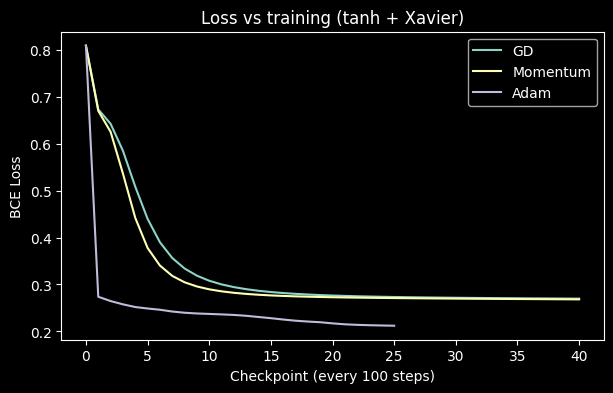

In [37]:

# tanh + Xavier
params_gd0 = init_params(d_in=2, h=10, seed=2, scheme="xavier")
params_m0  = init_params(d_in=2, h=10, seed=2, scheme="xavier")
params_a0  = init_params(d_in=2, h=10, seed=2, scheme="xavier")

params_gd0, hist_gd = train_gd(X, y, params_gd0, activation="tanh", lr=0.06, steps=4000)
params_m0,  hist_m  = train_momentum(X, y, params_m0, activation="tanh", lr=0.08, steps=4000, beta=0.9)
params_a0,  hist_a  = train_adam(X, y, params_a0, activation="tanh", lr=0.03, steps=2500)

plt.figure(figsize=(7,4))
plt.plot(hist_gd["loss"], label="GD")
plt.plot(hist_m["loss"], label="Momentum")
plt.plot(hist_a["loss"], label="Adam")
plt.xlabel("Checkpoint (every 100 steps)")
plt.ylabel("BCE Loss")
plt.title("Loss vs training (tanh + Xavier)")
plt.legend()
plt.show()


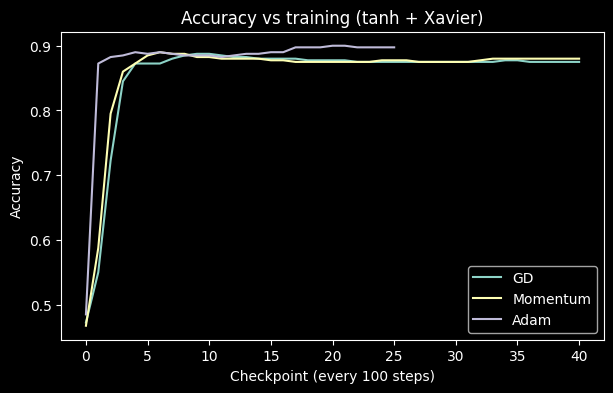

In [39]:
plt.figure(figsize=(7,4))
plt.plot(hist_gd["acc"], label="GD")
plt.plot(hist_m["acc"], label="Momentum")
plt.plot(hist_a["acc"], label="Adam")
plt.xlabel("Checkpoint (every 100 steps)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs training (tanh + Xavier)")
plt.legend()
plt.show()


## 6) Decision Surface (2D)

Probability shading + boundary at 0.5, plus mistake markers.


In [ ]:

def plot_nn_decision_surface(X, y, params, activation="tanh", title="NN Decision Surface", show_mistakes=True):
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 350),
        np.linspace(y_min, y_max, 350)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    P, _ = forward(grid, params, activation=activation)
    P = P.reshape(xx.shape)

    plt.figure(figsize=(7,6))
    im = plt.imshow(P, origin="lower", extent=(x_min,x_max,y_min,y_max), aspect="auto", alpha=0.30)
    cbar = plt.colorbar(im)
    cbar.set_label("p(Class 1 | x)")

    plt.contour(xx, yy, P, levels=[0.5], colors="white", linewidths=2)

    plt.scatter(X[y==0,0], X[y==0,1], color="blue", alpha=0.75, label="True Class 0")
    plt.scatter(X[y==1,0], X[y==1,1], color="red",  alpha=0.75, label="True Class 1")

    if show_mistakes:
        pred = predict_class(X, params, activation=activation)
        wrong = pred != y
        plt.scatter(X[wrong & (pred==1),0], X[wrong & (pred==1),1],
                    marker="x", s=90, linewidths=2, color="blue", label="Wrong, Pred 1")
        plt.scatter(X[wrong & (pred==0),0], X[wrong & (pred==0),1],
                    marker="x", s=90, facecolors="none", edgecolors="red", linewidths=2,
                    label="Wrong, Pred 0")

    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend(loc="upper right")
    plt.show()

plot_nn_decision_surface(X, y, params_a0, activation="tanh", title="NN (tanh + Xavier + Adam)")



## 7) 3D Probability Surface (Pins)

Surface = \(p(\text{Class 1}|x)\). Points sit slightly above their predicted probability.


In [ ]:

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def nn_prob_fn(Xq, params, activation="tanh"):
    P, _ = forward(Xq, params, activation=activation)
    return P.reshape(-1)

def plot_prob_surface_3d_pins(X, y, params, activation="tanh", title="NN 3D Surface — pins", n_points=220, show_pins=False):
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 95),
        np.linspace(y_min, y_max, 95)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = nn_prob_fn(grid, params, activation=activation).reshape(xx.shape)

    idx = np.random.choice(len(X), size=min(n_points, len(X)), replace=False)
    Xs = X[idx]
    ys = y[idx]
    p = nn_prob_fn(Xs, params, activation=activation)
    eps = 0.02
    z_pts = np.clip(p + eps, 0, 1)

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(xx, yy, Z, alpha=0.40, linewidth=0, antialiased=True)

    if show_pins:
        for i in range(len(Xs)):
            ax.plot([Xs[i,0], Xs[i,0]],
                    [Xs[i,1], Xs[i,1]],
                    [p[i], z_pts[i]],
                    color="white", alpha=0.40, linewidth=1)

    ax.scatter(Xs[ys==0,0], Xs[ys==0,1], z_pts[ys==0], color="blue", alpha=0.85, s=22, depthshade=False, label="Class 0")
    ax.scatter(Xs[ys==1,0], Xs[ys==1,1], z_pts[ys==1], color="red",  alpha=0.85, s=22, depthshade=False, label="Class 1")
    ax.contour(xx, yy, Z, levels=[0.5], colors="white", linewidths=3, offset=0.5)

    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.set_zlabel("p(Class 1 | x)")
    ax.set_zlim(0, 1)
    ax.set_title(title)
    ax.legend(loc="upper right")
    ax.view_init(elev=25, azim=-60)
    plt.show()

params_un = init_params(d_in=2, h=10, seed=2, scheme="xavier")
plot_prob_surface_3d_pins(X, y, params_un, activation="tanh", title="NN 3D Surface (Untrained) — pins")

In [ ]:
plot_prob_surface_3d_pins(X, y, params_a0, activation="tanh", title="NN 3D Surface (Trained) — pins")


## Key Takeaways (Lesson 12)

- **Backprop = chain rule**, applied systematically. Once vectorized, it scales.
- With **sigmoid + BCE**, the output gradient simplifies:
  \[
  \frac{\partial \mathcal{L}}{\partial Z_2} = \hat{y} - y
  \]
- **Gradient checking** is your safety net: do it once per architecture.
- **Initialization matters** because activations can saturate:
  - Xavier is a strong default for tanh.
  - He is a strong default for ReLU.
- **Optimizers change training behavior:**
  - GD: steady but can be slow
  - Momentum: smoother + faster
  - Adam: usually converges fastest with minimal tuning
- Visualization is debugging:
  - decision surface shows learned geometry
  - 3D surface shows how confidence deforms during training
